In [1]:
import pandas as pd
import numpy as np

In [11]:
data = pd.read_csv('Data/Data_for_UCI_named.csv')

In [12]:
data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [14]:
data['stabf'].value_counts()

unstable    6380
stable      3620
Name: stabf, dtype: int64

In [15]:
import matplotlib.pyplot as plt

In [19]:
X = data.drop(columns='stabf', axis=1)
y = data['stabf'].replace({'stable': 1, 'unstable': 0})

In [18]:
from sklearn.decomposition import PCA

In [22]:
pca_ = PCA(n_components=2)
X_pca = pca_.fit_transform(X)
X['pca1'] = X_pca[:, 0]
X['pca2'] = X_pca[:, 1]

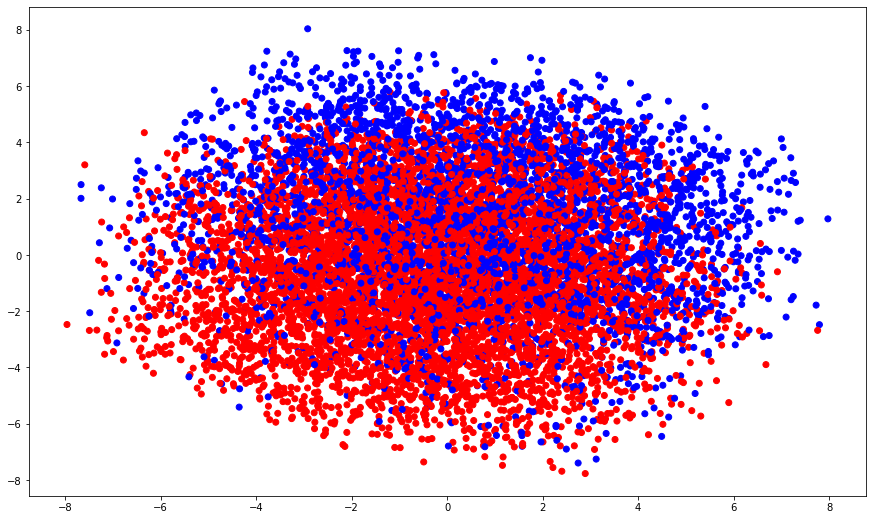

In [29]:
cm = np.array(['r', 'b'])
plt.figure(figsize=(15,9))
plt.scatter(X['pca1'], X['pca2'], c=cm[y.values.ravel()])

In [30]:
from lightgbm import LGBMClassifier

In [31]:
from sklearn.model_selection import train_test_split

In [33]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, recall_score, precision_score

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [35]:
model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1630
           1       1.00      1.00      1.00       870

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



In [92]:
data_f = pd.concat([X, y], axis=1)

In [105]:
positive_sample = data_f[data_f['stabf'] == 1].sample(frac=0.25)
positive_sample['labels'] = 1

In [106]:
data_f['labels'] = -1
data_f.loc[positive_sample.index, 'labels'] = 1

In [112]:
neg_sample = data_f[data_f['labels']==-1][:positive_sample.shape[0]]
neg_sample['labels'] = 0
test_sample = data_f[data_f['labels']==-1][positive_sample.shape[0]:]
train_sample = pd.concat([positive_sample, neg_sample], axis=0)

In [113]:
model2 = LGBMClassifier()
model2.fit(train_sample.iloc[:, :-2], train_sample.iloc[:, -1])
y_pred2 = model2.predict(test_sample.iloc[:, :-2])
print(classification_report(test_sample.iloc[:, -2], y_pred2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      5760
           1       1.00      0.93      0.97      2430

    accuracy                           0.98      8190
   macro avg       0.99      0.97      0.98      8190
weighted avg       0.98      0.98      0.98      8190



In [114]:
def model_result(name, y_true, y_pred):
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    df = pd.DataFrame({'Model name':[name],
                       'F1 Score': [f1],
                      'Precision score': [precision],
                      'Recall Score': [recall],
                      'ROC AUC Score': [roc_auc]})
    return df

In [115]:
res1 = model_result('LightGBM(Base)', y_test, y_pred)
res2 = model_result('LightGBM(random negative sampling)', test_sample.iloc[:, -2], y_pred2)
res = pd.concat([res1, res2])
res.head()

,Model name,F1 Score,Precision score,Recall Score,ROC AUC Score
0,LightGBM(Base),1.000000,1.0,1.000000,1.000000
0,LightGBM(random negative sampling),0.965517,1.0,0.933333,0.966667


Качество модели ухудшилось, но все еще осталось на достаточно высоком уровне.